### Getting Set Up: Load in Sheets, Set Indices, Drop Covariance

In [7]:
!pip install -r requirements_2.txt
!pip install matplotlib

  Using cached CFEDemands-0.6.1-py2.py3-none-any.whl (45 kB)
  Using cached dvc-3.49.0-py3-none-any.whl (450 kB)
  Using cached celery-5.3.6-py3-none-any.whl (422 kB)
  Using cached dvc_http-2.32.0-py3-none-any.whl (12 kB)
  Using cached gto-1.7.1-py3-none-any.whl (46 kB)
  Using cached dvc_task-0.4.0-py3-none-any.whl (21 kB)


In [8]:
# just setting up functions to do demand stuff with 

import numpy as np
import pandas as pd
from cfe.estimation import drop_columns_wo_covariance
from cfe import Regression
!pip install fooddatacentral

  Using cached fooddatacentral-1.0.10-py3-none-any.whl (6.8 kB)


In [9]:
hh_urban = pd.read_csv('HH_Urban.csv')
hh_rural = pd.read_csv('HH_Rural.csv')
exp_urban = pd.read_csv('Expenditures_Urban.csv')
exp_rural = pd.read_csv('Expenditures_Rural.csv')

In [10]:
# format urban expenditures and household characteristics
exp_urban.set_index(['i', 't', 'm'], inplace=True)
exp_urban.columns.name = 'j'

hh_urban.set_index(['i','t','m'],inplace=True)
hh_urban.columns.name = 'k'

In [11]:
# format rural expenditures and household characteristics
exp_rural.set_index(['i', 't', 'm'], inplace=True)
exp_rural.columns.name = 'j'

hh_rural.set_index(['i','t','m'],inplace=True)
hh_rural.columns.name = 'k'

In [12]:
# get log values for expenditures 

y_rural = np.log(exp_rural)
y_urban = np.log(exp_urban)


/srv/conda/lib/python3.9/site-packages/pandas/core/internals/blocks.py:393: RuntimeWarning: divide by zero encountered in log
  result = func(self.values, **kwargs)
/srv/conda/lib/python3.9/site-packages/pandas/core/internals/blocks.py:393: RuntimeWarning: invalid value encountered in log
  result = func(self.values, **kwargs)


In [13]:
d_rural = hh_rural
d_urban = hh_urban 

In [17]:
# import the no covariance column function, and apply to log expenditures
import cfe
from cfe.estimation import drop_columns_wo_covariance

y_rural = drop_columns_wo_covariance(y_rural,min_obs=17)
y_urban = drop_columns_wo_covariance(y_urban,min_obs=17)

# not really sure what this is doing, ask ChatGPT
use_rural = y_rural.index.intersection(d_rural.index)
use_urban = y_urban.index.intersection(d_urban.index)

# set them to specific indices per rural 
y_rural = y_rural.loc[use_rural,:]
y_urban = y_urban.loc[use_urban,:]

# set them to specific indices per rural 
d_rural = d_rural.loc[use_rural,:]
d_urban = d_urban.loc[use_urban,:]

### Now Actually Estimate Demand System

In [23]:
# this is a function that will return the initial expenditure 
# demand graph, for all goods and quantities (?)

def expenditure_demand(y, d): 
    # stack dataframes
    y = y.stack()
    d = d.stack()
    # remove duplicate indices
    idx = np.unique(d.index.values, return_index = True)[1]
    d = d.iloc[idx]
    result = cfe.Regression(y=y,d=d,min_obs=17,min_prop_items=0,alltm=False)
    df = pd.DataFrame({'y':y,'yhat':result.get_predicted_log_expenditures()})
    return result, df

In [24]:
result, df = expenditure_demand(y_rural, d_rural)

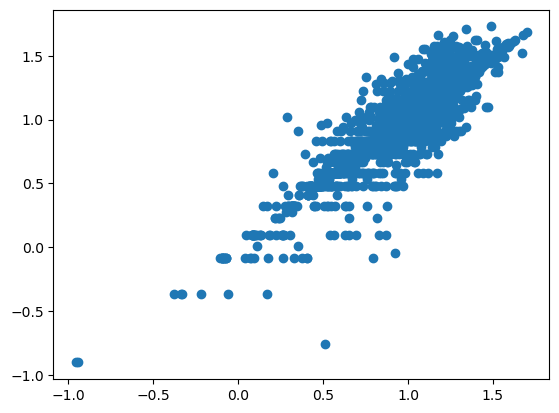

In [26]:
# and plotting it: 
import matplotlib.pyplot as plt
#%matplotlib notebook

plt.scatter(df['yhat'], df['y'])

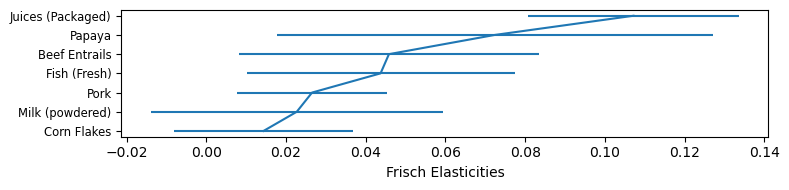

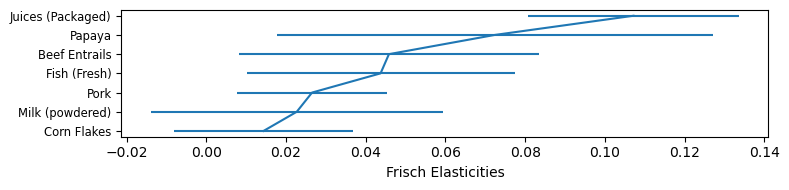

In [27]:
# can grab the coefficient values, which represent a quasi-income demand elasticity 
coefficients = result.get_beta().sort_values()

# can also plot this: 
result.graph_beta()


#### Estimating Demand for Individual Goods and Household Compositions

In [28]:
# check out: 
result.gamma



k,Unnamed: 0,Males 00-03,Females 00-03,Males 04-08,Females 04-08,Males 09-13,Females 09-13,Males 14-18,Females 14-18,Males 19-30,...,Males 51-99,Females 51-99,log HSize,Rural,total,under_4,frac_under_4,under_9,frac_under_9,Constant
j,,,,,,,,,,,,,,,,,,,,,
Avocado,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Bananas,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Beans,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Beef,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Beef Entrails,9.184620e-07,0.056871,-0.008321,-0.048062,-0.02038,-0.014546,-0.008689,-0.020556,0.004949,0.031476,...,0.005217,0.030323,0.197923,-1.110223e-16,-0.008577,0.04855,-0.356744,-0.019891,0.091297,0.85336
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Tomato Sauce,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Tomatoes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Watermelon,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [29]:
# now writing function to get demand curves for certain goods

def specific_demand(result, food = ''): 
    
    xhat = result.predicted_expenditures() # grab household vector 
    p = np.exp(result.get_Ar()) # relative prices deduced in model
    scale = np.linspace(0.5, 2, 20) # y axis scale
    
    xbar = xhat.groupby(['i','t','m']).sum() # Total food expenditures per household
    pbar = p.xs(level='t').groupby('j').mean()
    
    def my_prices(p0,p=pbar):
        """
        This just changes the price of good j, holding other prices constant
        """
        p = p.copy()
        p.loc[food] = p0
        return p
    
    plt.plot([result.demands(xbar.quantile(0.25),my_prices(pbar[food]*s,pbar))[food] for s in scale],scale)


In [18]:
r = result
xhat = r.predicted_expenditures()
# Implied relative prices
p = np.exp(r.get_Ar())

<IPython.core.display.Javascript object>


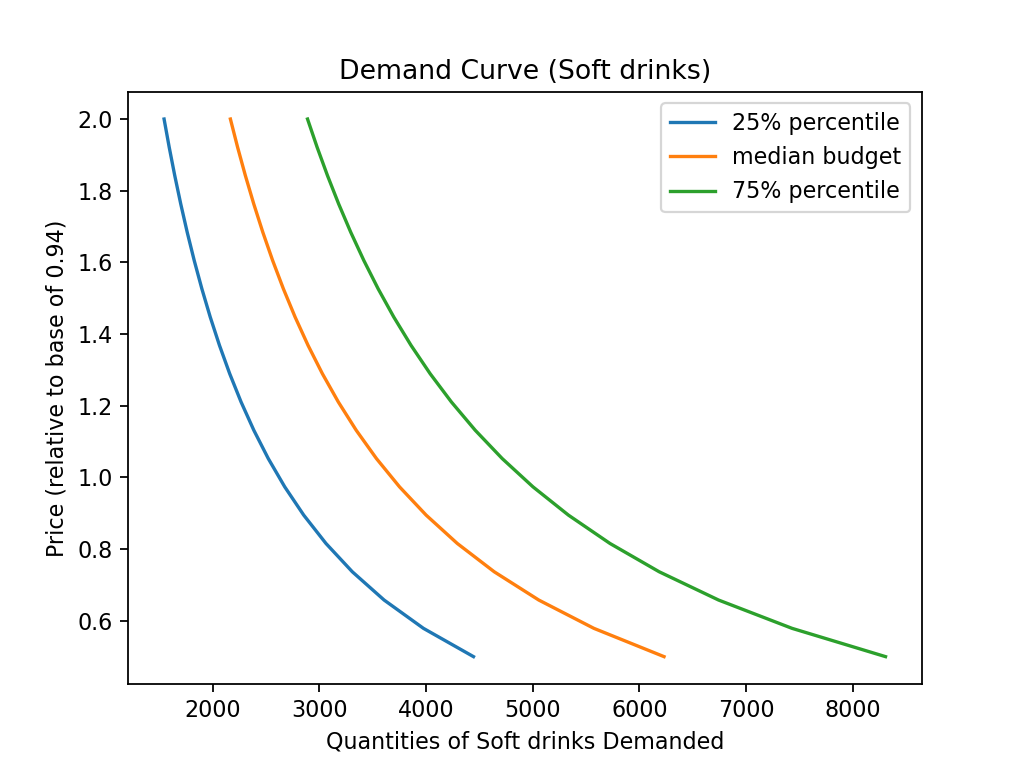

Text(0.5, 1.0, 'Demand Curve (Soft drinks)')

In [19]:
import matplotlib.pyplot as plt
%matplotlib notebook

use = 'Soft drinks'
scale = np.linspace(.5,2,20)

# Total food expenditures per household
xbar = xhat.groupby(['i','t','m']).sum()

# Reference budget
xref = xbar.quantile(0.5)  # Household at 0.5 quantile is median

# Reference prices
pbar = p.xs('2014-15',level='t').groupby('j').mean()
#pbar = pbar[use]

def my_prices(p0,p=pbar,j='Soft drinks'):
    """
    This just changes the price of good j, holding other prices constant
    """
    p = p.copy()
    p.loc[j] = p0
    return p

# Demand for Soft drinks for household at 25% percentile
plt.plot([r.demands(xbar.quantile(0.25),my_prices(pbar[use]*s,pbar))[use] for s in scale],scale, label='25% percentile')

# Demand for Soft drinks for household at median budget
plt.plot([r.demands(xref,my_prices(pbar[use]*s,pbar))[use] for s in scale],scale, label='median budget')

# Demand for Soft drinks for household at 75% percentile
plt.plot([r.demands(xbar.quantile(0.75),my_prices(pbar[use]*s,pbar))[use] for s in scale],scale, label='75% percentile')
plt.legend()
plt.ylabel(f"Price (relative to base of {pbar[use]:.2f})")
plt.xlabel(f"Quantities of {use} Demanded")
plt.title(f"Demand Curve ({use})")

In [25]:
pd.DataFrame.stack?

Signature: pd.DataFrame.stack(self, level: 'Level' = -1, dropna: 'bool' = True)
Docstring:
Stack the prescribed level(s) from columns to index.

Return a reshaped DataFrame or Series having a multi-level
index with one or more new inner-most levels compared to the current
DataFrame. The new inner-most levels are created by pivoting the
columns of the current dataframe:

  - if the columns have a single level, the output is a Series;
  - if the columns have multiple levels, the new index
    level(s) is (are) taken from the prescribed level(s) and
    the output is a DataFrame.

Parameters
----------
level : int, str, list, default -1
    Level(s) to stack from the column axis onto the index
    axis, defined as one index or label, or a list of indices
    or labels.
dropna : bool, default True
    Whether to drop rows in the resulting Frame/Series with
    missing values. Stacking a column level onto the index
    axis can create combinations of index and column values
    that are mis